# CNN example

Some code to show how the CNN finds ripples.

In [1]:
# Imports
import sys
import numpy as np

sys.path.insert(1, '../cnn/')

## Load data

In [2]:
import os
sys.path.insert(1, '../../figshare')
from figshare import Figshare

fshare = Figshare()
article_id = 14960085
datapath = "figshare_%d"%(article_id)
shank = 1

if os.path.isdir(datapath):
    print("Data already exists. Moving on.")
else:
    print("Downloading data... Please wait")
    fshare.retrieve_files_from_article(article_id)
    print("Data downloaded!")


Data already exists. Moving on.


In [3]:
from load_data import load_data, z_score_normalization
downsampled_fs = 1250

# Load data and downsample it to 1250 Hz
data = load_data(path=datapath, shank=shank, downsampled_fs=downsampled_fs)

print("Shape of loaded data after downsampling: ", np.shape(data))

# Normalize it with z-score
data = z_score_normalization(data)

Shape of loaded data after downsampling:  (930261, 8)


In [11]:
overlapping = True
window_size = 0.0128


if overlapping:
    from load_data import generate_overlapping_windows
    
    stride = 0.0064

    # Separate the data into 12.8ms windows with 6.4ms overlapping
    X = generate_overlapping_windows(data, window_size, stride, downsampled_fs)

    print("Number of windows to evaluate: ", X.shape[0])
else:
    stride = window_size
    X = np.expand_dims(data, 0)

Number of windows to evaluate:  116283


## Load trained CNN model

In [5]:
import tensorflow.keras.backend as K
import tensorflow.keras as kr

optimizer = kr.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
model = kr.models.load_model("../../model", compile=False)
model.compile(loss="binary_crossentropy", optimizer=optimizer)

print("Model loaded!")

Model loaded!


## Make predictions with model

In [12]:
predictions = model.predict(X, verbose=True)

3634/3634 [==============================] - 6s 2ms/step


### Get predicted ripples times

In [13]:
from format_predictions import get_predictions_indexes

pred_indexes = get_predictions_indexes(data, predictions, window_size=window_size, stride=stride, fs=1250, threshold=0.7)

<IPython.core.display.Javascript object>


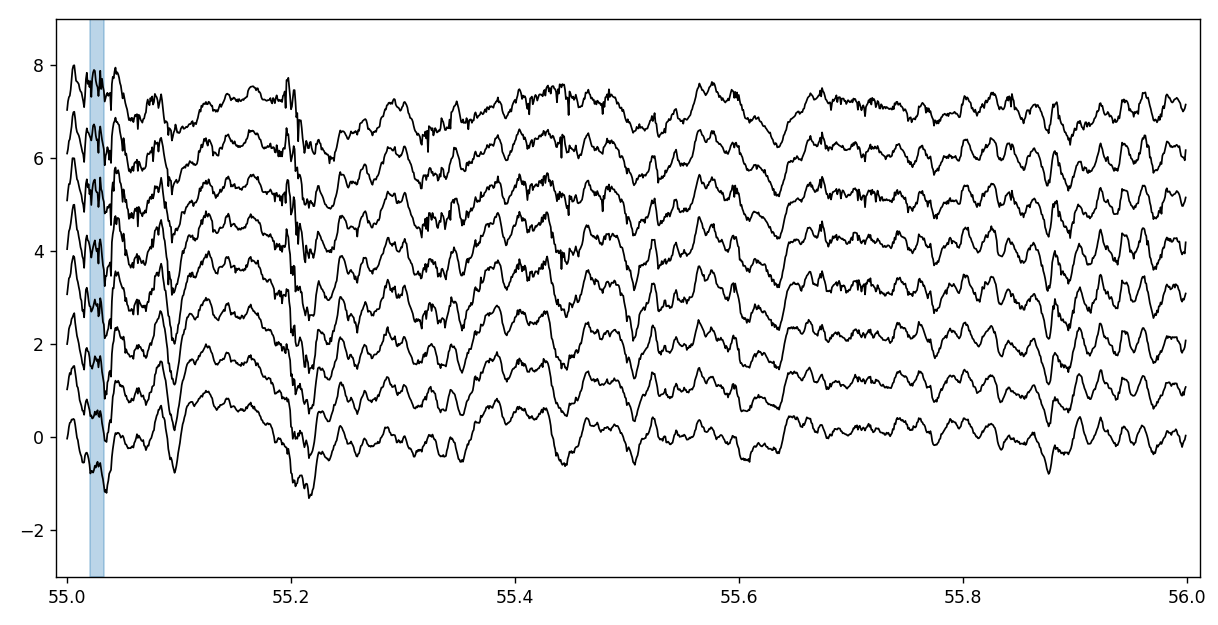

interactive(children=(BoundedIntText(value=0, description='Second:', layout=Layout(width='900px'), max=744), O…

In [14]:
%matplotlib notebook
from ipywidgets import interact, Layout
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

k = 0
data_size = data.shape[0]
data_dur = data_size / downsampled_fs
ini_idx = int(k * downsampled_fs)
end_idx = np.minimum(int((k+1) * downsampled_fs), data_size-1)
times = np.arange(data_size) / downsampled_fs

pos_mat = list(range(data.shape[1]-1, -1, -1)) * np.ones((end_idx-ini_idx, data.shape[1]))

fig = plt.figure(figsize=(9.75,5))
ax = fig.add_subplot(1, 1, 1)
ax.set_ylim(-3, 9)
ax.margins(x=0)
plt.tight_layout()

lines = ax.plot(times[ini_idx:end_idx], data[ini_idx:end_idx, :]*1/np.max(data[ini_idx:end_idx, :], axis=0) + pos_mat, color='k', linewidth=1)

fills = []
for pred in pred_indexes:
    if (pred[0] >= ini_idx and pred[0] <= end_idx) or (pred[1] >= ini_idx and pred[1] <= end_idx):
        rip_ini = (pred[0] - ini_idx) / downsampled_fs
        rip_end = (pred[1] - ini_idx) / downsampled_fs
        fill = ax.fill_between([rip_ini, rip_end], [-3, -3], [9, 9], color="tab:blue", alpha=0.3)
        fills.append(fill)


def update(k=0):
    ini_idx = int(k * downsampled_fs)
    end_idx = np.minimum(int((k+1) * downsampled_fs), data_size-1)

    label_format = '{:,.1f}'
    ax.xaxis.set_major_locator(mticker.MaxNLocator(6))
    x_ticks = ax.get_xticks().tolist()
    ax.xaxis.set_major_locator(mticker.FixedLocator(x_ticks))
    ax.set_xticklabels([label_format.format(x+k) for x in x_ticks])
    
    for i in range(len(lines)):
        #lines[i].set_xdata(times[ini_idx:end_idx])
        lines[i].set_ydata(data[ini_idx:end_idx, i]*1/np.max(data[ini_idx:end_idx, i], axis=0) + pos_mat[:,i])

    for fill in fills:
        fill.remove()
    
    fills.clear()
    for pred in pred_indexes:
        if (pred[0] >= ini_idx and pred[0] <= end_idx) or (pred[1] >= ini_idx and pred[1] <= end_idx):
            rip_ini = (pred[0] - ini_idx) / downsampled_fs
            rip_end = (pred[1] - ini_idx) / downsampled_fs
            fill = ax.fill_between([rip_ini, rip_end], [-3, -3], [9, 9], color="tab:blue", alpha=0.3)
            fills.append(fill)
    
    fig.canvas.draw_idle()

interact(update, k = widgets.BoundedIntText(value=0, min=0, max=data_dur, step=1, description="Second:", layout=Layout(width='900px')));